In [2]:
import numpy as np;
import time;

In [3]:
import matplotlib.pyplot as plt;
%matplotlib inline

In [4]:
from RBComb.SerialBridge import *
from RBComb.RBComb576 import *
from RBComb.LaserInterface import *
from RBComb.Helper.BoardPinout import *
from RBComb.Helper.BoardUnits import *;
from RBComb.Helper.FunctionInterpolator import *

In [5]:
# This document shows how 2 signal generators with positive/negative amplitude can be combined
# to make a single signal generator with arbitrary phase.
# This is done by phase-shifting one of the generators by 90 degrees so it acts as the imaginary
# part of the amplitude.

In [6]:
# Construct bridge:
currentBridge = SerialBridge('/dev/tty.usbserial-FT3J6M59B', True, 300);

# Note: the correct baud rate is 5'000'000 but it is not supported in Mac OS X
# The solution is to modify the serial port driver so it aliases ("pretends") to be working at a standard
# rate of 300, but in reality it works at 5000000. This is done by modifying /Library/Extensions/FTDIUSBSerialDriver.kext
# following the guide https://www.ftdichip.com/Support/Documents/TechnicalNotes/TN_105%20Adding%20Support%20for%20New%20FTDI%20Devices%20to%20Mac%20Driver.pdf
# And subsequently disabling the "trusted platform" features of mac since it would no longer accept the modified extension

In [7]:
# Make sure clock is off
currentBridge.disableClock();

In [8]:
# Construct RBComb576
rbComb = RBComb576(currentBridge);

In [9]:
# Construct laser
laser = LaserInterface(currentBridge);

In [10]:
# Construct helper objects:
pinout = BoardPinout();
units = BoardUnits();

In [11]:
# Make sure we don't have garbage from previous runs in the serial port read buffer
currentBridge.flushInput()

In [13]:
# Read displacement from laser to see if everything is fine
currentBridge.selectLaser();
laserDisplacement = laser.requestDisplacement(axis=3)
print(f'{laserDisplacement/1e9} [mm]')

19.396136983 [mm]


In [14]:
currentBridge.selectAllBoards()

In [53]:
currentBridge.selectAllBoards()
# We use the interpolator to raise the signal to V/2 as the output cannot take negative values
interpolator = FunctionInterpolator();
constantFunction = interpolator.getConstantFunction(0.5)

# Upload offset function to the device (Takes 10 seconds, do only once per "session")
for i in range(576):
    rbComb.setTaylorCoefficients(i, False, constantFunction);
    

# Ramp up (won't take effect until turning on the clock)
rbComb.outputRampUp();

In [61]:
currentBridge.enableClock();
time.sleep(4.0);
currentBridge.disableClock();

In [62]:
excitationFrequency = 30000;
excitationPhase = 0;
excitationAmplitude = 1.25;

In [123]:
currentBridge.selectAllBoards()
rbComb.setCurrentState([1,0,0,0,0]);
rbComb.setGain(True);

# Configure phases:
rbComb.setPhase(0, units.convertDegreesPhaseToInteger(excitationPhase))

# Configure frequencies:
rbComb.setFrequency(0, units.convertFrequencyHzToInteger(excitationFrequency))

# Make sure that the generators don't sweep
for i in range(4):
    rbComb.setSweepFrequencyStep(i,0);

# Configure amplitudes: 
for i in range(576):
    rbComb.setAmplitude(0,i,units.convertNormalizedAmplitudeToInteger(excitationAmplitude/2.5));
    rbComb.setAmplitude(1,i,0);
    rbComb.setAmplitude(2,i,0);
    rbComb.setAmplitude(3,i,0);

In [124]:
def performExperiment(frequency):
    currentBridge.selectAllBoards();
    rbComb.setPhase(0, units.convertDegreesPhaseToInteger(0));
    rbComb.setFrequency(0, units.convertFrequencyHzToInteger(frequency))
    
    currentBridge.selectLaser();
    laser.scheduleAcquisition(axis=3, delay=50000)
    currentBridge.selectAllBoards();
    currentBridge.enableClock();
    time.sleep(0.1)
    # Boards will not become disabled because the clock is on so they don't see the next command:
    currentBridge.selectLaser();
    while not laser.isAcquisitionFinished():
        time.sleep(0.1);
    print('Acquisition finished!');
    currentBridge.disableClock();
    # Warning!!! Now both board and laser are selected, because the boards don't know we selected the laser
    # because we did while the clock was on.
    currentBridge.selectLaser();
    results = laser.requestTimeTrace();
    signal = results[:,1] - np.average(results[:,1]);
    tcoord = results[:,0]/1e8;
    X = np.average(signal*np.cos(tcoord*frequency*2.0*np.pi));
    Y = np.average(signal*np.sin(tcoord*frequency*2.0*np.pi));
    return 2.0*np.sqrt(X**2 + Y**2);

In [107]:
print(performExperiment(5000));
print(performExperiment(5000));

Acquisition finished!
[[5.90000000e+01 1.93969803e+10]
 [2.91000000e+02 1.93969791e+10]
 [5.23000000e+02 1.93969798e+10]
 ...
 [7.60169600e+06 1.93969760e+10]
 [7.60192800e+06 1.93969742e+10]
 [7.60216000e+06 1.93969809e+10]]
Acquisition finished!
[[1.37000000e+02 1.93969788e+10]
 [3.69000000e+02 1.93969756e+10]
 [6.01000000e+02 1.93969761e+10]
 ...
 [7.60177400e+06 1.93969764e+10]
 [7.60200600e+06 1.93969715e+10]
 [7.60223800e+06 1.93969780e+10]]


In [112]:
q  = performExperiment(1000)

Acquisition finished!


In [113]:
q

7234.443890623983

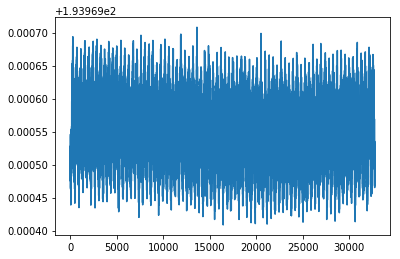

In [109]:
plt.plot(q[:,1]/1e8)

In [129]:
frequencies = np.linspace(20000, 26000, 1000);
results = [];
for frequency in frequencies: 
    results.append(performExperiment(frequency));

Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisitio

Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisitio

Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisition finished!
Acquisitio

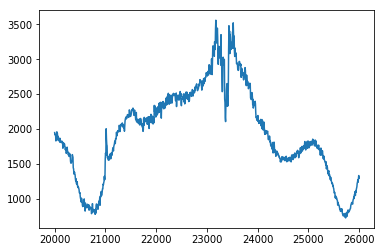

In [130]:
#results2 = results;
plt.plot(frequencies,results);